In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import sqlite3
from pprint import pprint

from io_cost import get_io_cost
from sqlite_helper import get_thread_ids_from_sqlite

# im being really lazy here, just want to get something working
%env OPENAI_API_KEY=this-doesnt-matter
from agent import make_graph

env: OPENAI_API_KEY=this-doesnt-matter
parentdir /Users/gbolet/hecbench-roofline/qdecomp-langgraph-studio/kernel-survey/dataset-gen/manual-classification
dataset_path /Users/gbolet/hecbench-roofline/qdecomp-langgraph-studio/kernel-survey/dataset-gen/manual-classification/kernels_to_inference_balanced.csv
Azure model could not be setup correctly! Falling back to OpenAI model in its place.
Error: Missing credentials. Please pass one of `api_key`, `azure_ad_token`, `azure_ad_token_provider`, or the `AZURE_OPENAI_API_KEY` or `AZURE_OPENAI_AD_TOKEN` environment variables.


# Baseline Experiments Results Visualization

In [2]:
db_dir = './checkpoints/'

# get all the sqlite files in the db_dir
sqlite_files = [f for f in os.listdir(db_dir) if f.endswith('.sqlite')]

for sqlite_file in sqlite_files:
    print(f"Processing [{sqlite_file}]") 


# keep only the ones with gpt-5-mini in the name
sqlite_files = [f for f in sqlite_files if 'gpt-5-mini' in f]

print(sqlite_files)

Processing [openai-gpt-5-mini:simplePrompt:openrouter.sqlite]
Processing [openai-gpt-4.1-mini:fullPrompt:openrouter.sqlite]
['openai-gpt-5-mini:simplePrompt:openrouter.sqlite']


In [ ]:


def split_thread_id_to_parts(thread_id: str) -> dict[str, str]:
    # split the thread_id into model_name, prompt_type, provider_name
    parts = thread_id.split(':')
    if len(parts) != 10:
        raise ValueError(f"Invalid thread_id format: {thread_id}")

    # the different parts are:
    # combined_name, model name, provider url, trial number, prompt type, variant type, nnz_flop_state, top_p, temp
    to_return = {
        'combined_name': parts[0],
        'model_name': parts[1],
        'provider': parts[2] + parts[3],
        'trial_number': parts[4],
        'prompt_type': parts[5],
        'variant_type': parts[6],
        'nnz_flop_state': parts[7],
        'top_p': parts[8],
        'temp': parts[9],
    }
    return to_return

In [4]:
df = pd.DataFrame()

for sqlite_file in sqlite_files:
    full_path = os.path.join(db_dir, sqlite_file)
    thread_ids = get_thread_ids_from_sqlite(full_path)
    graph = make_graph(full_path)

    for thread_id in thread_ids:
        #print(f"Processing thread_id [{thread_id}]")
        parts = split_thread_id_to_parts(thread_id)

        # get the state for the thread_id
        config = {'configurable': {'thread_id': thread_id}}
        state = graph.get_state(config)
        #print(dir(state))
        #print(state.next)

        full_final_state_dict = parts | state.values

        state_keys = list(state.values.keys())
        print(state_keys)

        # if there is no next state and no tasks left, then we had a successful execution
        if (not state.next) and (not state.tasks):
            #full_final_state_dict['error'] = 'Success'
            full_final_state_dict['state_of_failure'] = None
            assert 'raw_flop_counts' in state_keys, f"raw_flop_counts not in state keys: {state_keys} -- this was supposed to be a successful run..."

            if len(state.values['total_cost']) != 1:
                print(f'thread_id: {thread_id} has multiple cost values: {state.values["total_cost"]}')
                print(f'\t input_tokens: {state.values["input_tokens"]}')
                print(f'\t output_tokens: {state.values["output_tokens"]}')
                print('tasks')
                pprint(state.tasks)
                print('metadata')
                pprint(state.metadata)
                print('--------------------------------------------\n')
        else:
            # we had an error, it should be written in the tasks error
            failure_task = state.tasks[0]
            error = str(failure_task.error)
            #print(state.tasks)
            if 'JSONDecodeError' in error:
                error = 'JSONDecodeError'
            elif 'Invalid JSON' in error:
                error = 'Invalid JSON'
            #full_final_state_dict['error'] = error
            full_final_state_dict['state_of_failure'] = failure_task.name

        #print("thread_id:", thread_id)
        dict_df = pd.DataFrame([full_final_state_dict])
        df = pd.concat([df, dict_df], ignore_index=True)


Processing [./checkpoints/openai-gpt-5-mini:simplePrompt:openrouter.sqlite]
['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size', 'block_size', 'total_num_threads', 'empirical_sp_flop_count', 'empirical_dp_flop_count', 'prompt_type', 'input_tokens', 'output_tokens', 'total_cost', 'total_query_time', 'error']
['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size', 'block_size', 'total_num_threads', 'empirical_sp_flop_count', 'empirical_dp_flop_count', 'prompt_type', 'raw_flop_counts', 'predicted_sp_flop_count', 'predicted_dp_flop_count', 'predicted_sp_flop_count_explanation', 'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens', 'total_cost', 'total_query_time', 'error']
['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size', 'block_size', 'total_num_threads', 'empirical_sp_flop_count', 'empirical_dp_flop_count', 'prompt_type', 'raw_flop_counts', 'predicted_sp_flop_count', 'predicted_dp_flop_count', 'predicted_sp_

In [5]:
# print the dataframe data

df['generic_model_name'] = df['model_name'].apply(lambda x: x.split('/')[1] if '/' in x else x)

print(df.columns)
print(df)

Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'source_code', 'kernel_name', 'exec_args', 'grid_size', 'block_size',
       'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'raw_flop_counts', 'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'generic_model_name'],
      dtype='object')
                                     combined_name         model_name  \
0                (ace-cuda, boundaryConditionsPhi)  openai/gpt-5-mini   
1                     (adv-cuda, advCubatureHex3D)  openai/gpt-5-mini   
2                          (bh-cuda, ClearKernel1)  openai/gpt-5-mini   
3                          (bh-cuda, ClearKernel2)  openai/gpt-5-mini   
4         

In [6]:
print(df.columns)

print(f'DF Size: {df.shape}')

# print the df datatypes
# print(df.dtypes)

print(df.error.value_counts( dropna=False ))

Index(['combined_name', 'model_name', 'provider', 'trial_number',
       'prompt_type', 'variant_type', 'nnz_flop_state', 'top_p', 'temp',
       'source_code', 'kernel_name', 'exec_args', 'grid_size', 'block_size',
       'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'raw_flop_counts', 'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'generic_model_name'],
      dtype='object')
DF Size: (21, 29)
error
Success    20
[]          1
Name: count, dtype: int64


## Adjust some of the columns

In [7]:
def parse_total_cost(cost_list):
    if cost_list is None or len(cost_list) == 0:
        return None
    assert len(cost_list) == 1, f"Expected a single cost value, got: {cost_list}"
    return cost_list[0]

df['total_cost'] = df['total_cost'].apply(parse_total_cost)

def parse_total_query_time(time):
    if time is None or type(time) == list:
        return None
    return float(time)
df['total_query_time'] = df['total_query_time'].apply(parse_total_query_time)

#def parse_error(x):
#    if pd.isna(x):
#        return "Success"
#    elif "Invalid JSON" in str(x):
#        return "Invalid\nJSON"
#    elif "NoneType" in str(x):
#        return "NoneType\nReturned"
#    elif "TIMEOUT" in str(x):
#        return "Query\nTimeout"
#    return str(x)
#
#df['error'] = df['error'].apply(parse_error)
df['has_nz_flops'] = df['nnz_flop_state'].apply(lambda x: 'No' if x == 'Zero SP + DP FLOP' else 'Yes')

print(df['error'].value_counts())
print(df[df['error'] != 'Success'])


# percent difference, we add a small epsilon to avoid division by zero
df['percent_diff_sp'] = 100*(df['predicted_sp_flop_count'] - df['empirical_sp_flop_count']) / (df['empirical_sp_flop_count'] + 1e-9)
df['percent_diff_dp'] = 100*(df['predicted_dp_flop_count'] - df['empirical_dp_flop_count']) / (df['empirical_dp_flop_count'] + 1e-9)

error
Success    20
[]          1
Name: count, dtype: int64
                       combined_name         model_name  \
0  (ace-cuda, boundaryConditionsPhi)  openai/gpt-5-mini   

                       provider trial_number prompt_type variant_type  \
0  https//openrouter.com/api/v1            1      simple           OG   

      nnz_flop_state top_p temp  \
0  Zero SP + DP FLOP   0.1  0.2   

                                         source_code  ... total_query_time  \
0  -----------------------------------\nreference...  ...              NaN   

  error        state_of_failure raw_flop_counts predicted_sp_flop_count  \
0    []  query_for_flop_count_1             NaN                     NaN   

   predicted_dp_flop_count  predicted_sp_flop_count_explanation  \
0                      NaN                                  NaN   

  predicted_dp_flop_count_explanation generic_model_name  has_nz_flops  
0                                 NaN         gpt-5-mini            No  

[1 rows x 30 

In [8]:
# now we want to plot the prediction accuracy vs. the ground truth for each generic_model_name and prompt_type

def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple'):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type)]
    success_df = sub_df[(sub_df['error'] == 'Success')]

    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange')
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue')

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(f'CDF of Percent Differences \n({model_name} -- {prompt_type} prompt)')

    plt.tight_layout()
    plt.show()

    # what this plot tells us is that we care mostly about the <-1 % and >+1% predictions
    percents = [1, 5, 10, 50, 100]
    for perc in percents:
        num_sp_within_xpct = ((nnz_sp_data > -perc) & (nnz_sp_data < perc)).sum()
        num_sp_outside_xpct = ((nnz_sp_data <= -perc) | (nnz_sp_data >= perc)).sum()

        num_dp_within_xpct = ((nnz_dp_data > -perc) & (nnz_dp_data < perc)).sum()
        num_dp_outside_xpct = ((nnz_dp_data <= -perc) | (nnz_dp_data >= perc)).sum()

        total_sp = nnz_sp_data.shape[0]
        total_dp = nnz_dp_data.shape[0]

        print(f'SP FLOP: {num_sp_within_xpct} / {total_sp} ({100*num_sp_within_xpct/total_sp:.2f}%) within +/- {perc}%')
        print(f'SP FLOP: {num_sp_outside_xpct} / {total_sp} ({100*num_sp_outside_xpct/total_sp:.2f}%) outside +/- {perc}%')
        print(f'DP FLOP: {num_dp_within_xpct} / {total_dp} ({100*num_dp_within_xpct/total_dp:.2f}%) within +/- {perc}%')
        print(f'DP FLOP: {num_dp_outside_xpct} / {total_dp} ({100*num_dp_outside_xpct/total_dp:.2f}%) outside +/- {perc}%')
        print("\n")
    ##############################################


    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='total_query_time', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    return


Success DF Size: (20, 32)


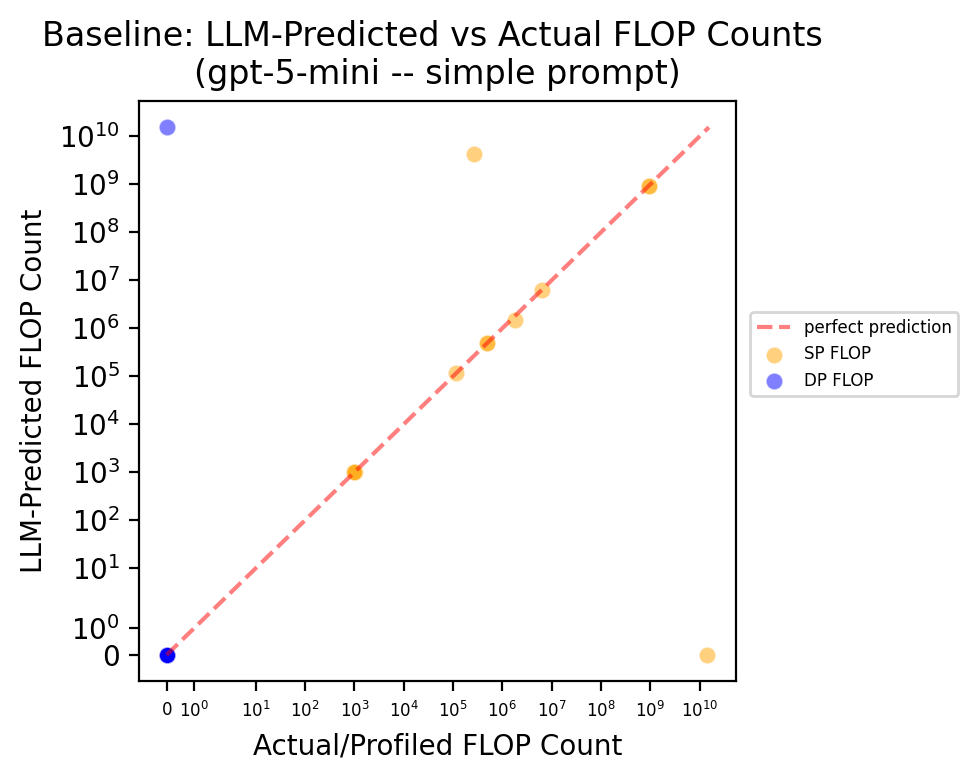

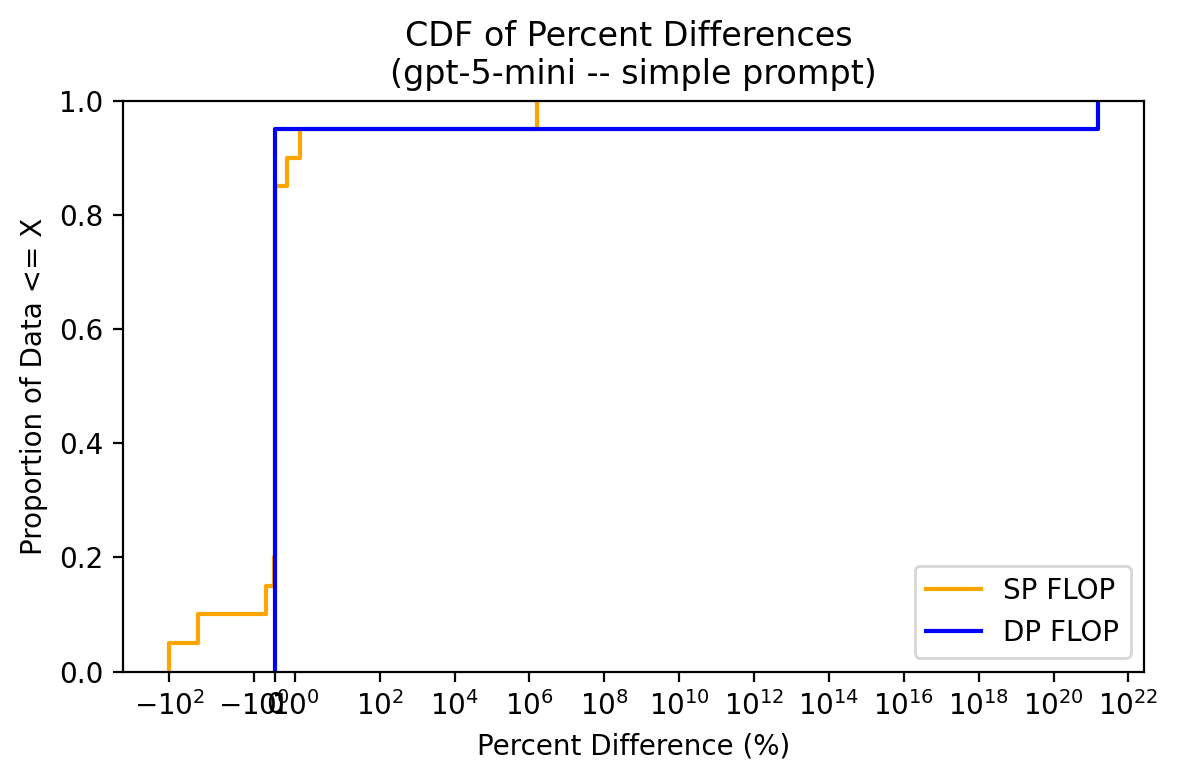

SP FLOP: 16 / 20 (80.00%) within +/- 1%
SP FLOP: 4 / 20 (20.00%) outside +/- 1%
DP FLOP: 19 / 20 (95.00%) within +/- 1%
DP FLOP: 1 / 20 (5.00%) outside +/- 1%


SP FLOP: 17 / 20 (85.00%) within +/- 5%
SP FLOP: 3 / 20 (15.00%) outside +/- 5%
DP FLOP: 19 / 20 (95.00%) within +/- 5%
DP FLOP: 1 / 20 (5.00%) outside +/- 5%


SP FLOP: 17 / 20 (85.00%) within +/- 10%
SP FLOP: 3 / 20 (15.00%) outside +/- 10%
DP FLOP: 19 / 20 (95.00%) within +/- 10%
DP FLOP: 1 / 20 (5.00%) outside +/- 10%


SP FLOP: 18 / 20 (90.00%) within +/- 50%
SP FLOP: 2 / 20 (10.00%) outside +/- 50%
DP FLOP: 19 / 20 (95.00%) within +/- 50%
DP FLOP: 1 / 20 (5.00%) outside +/- 50%


SP FLOP: 18 / 20 (90.00%) within +/- 100%
SP FLOP: 2 / 20 (10.00%) outside +/- 100%
DP FLOP: 19 / 20 (95.00%) within +/- 100%
DP FLOP: 1 / 20 (5.00%) outside +/- 100%




TypeError: unhashable type: 'list'

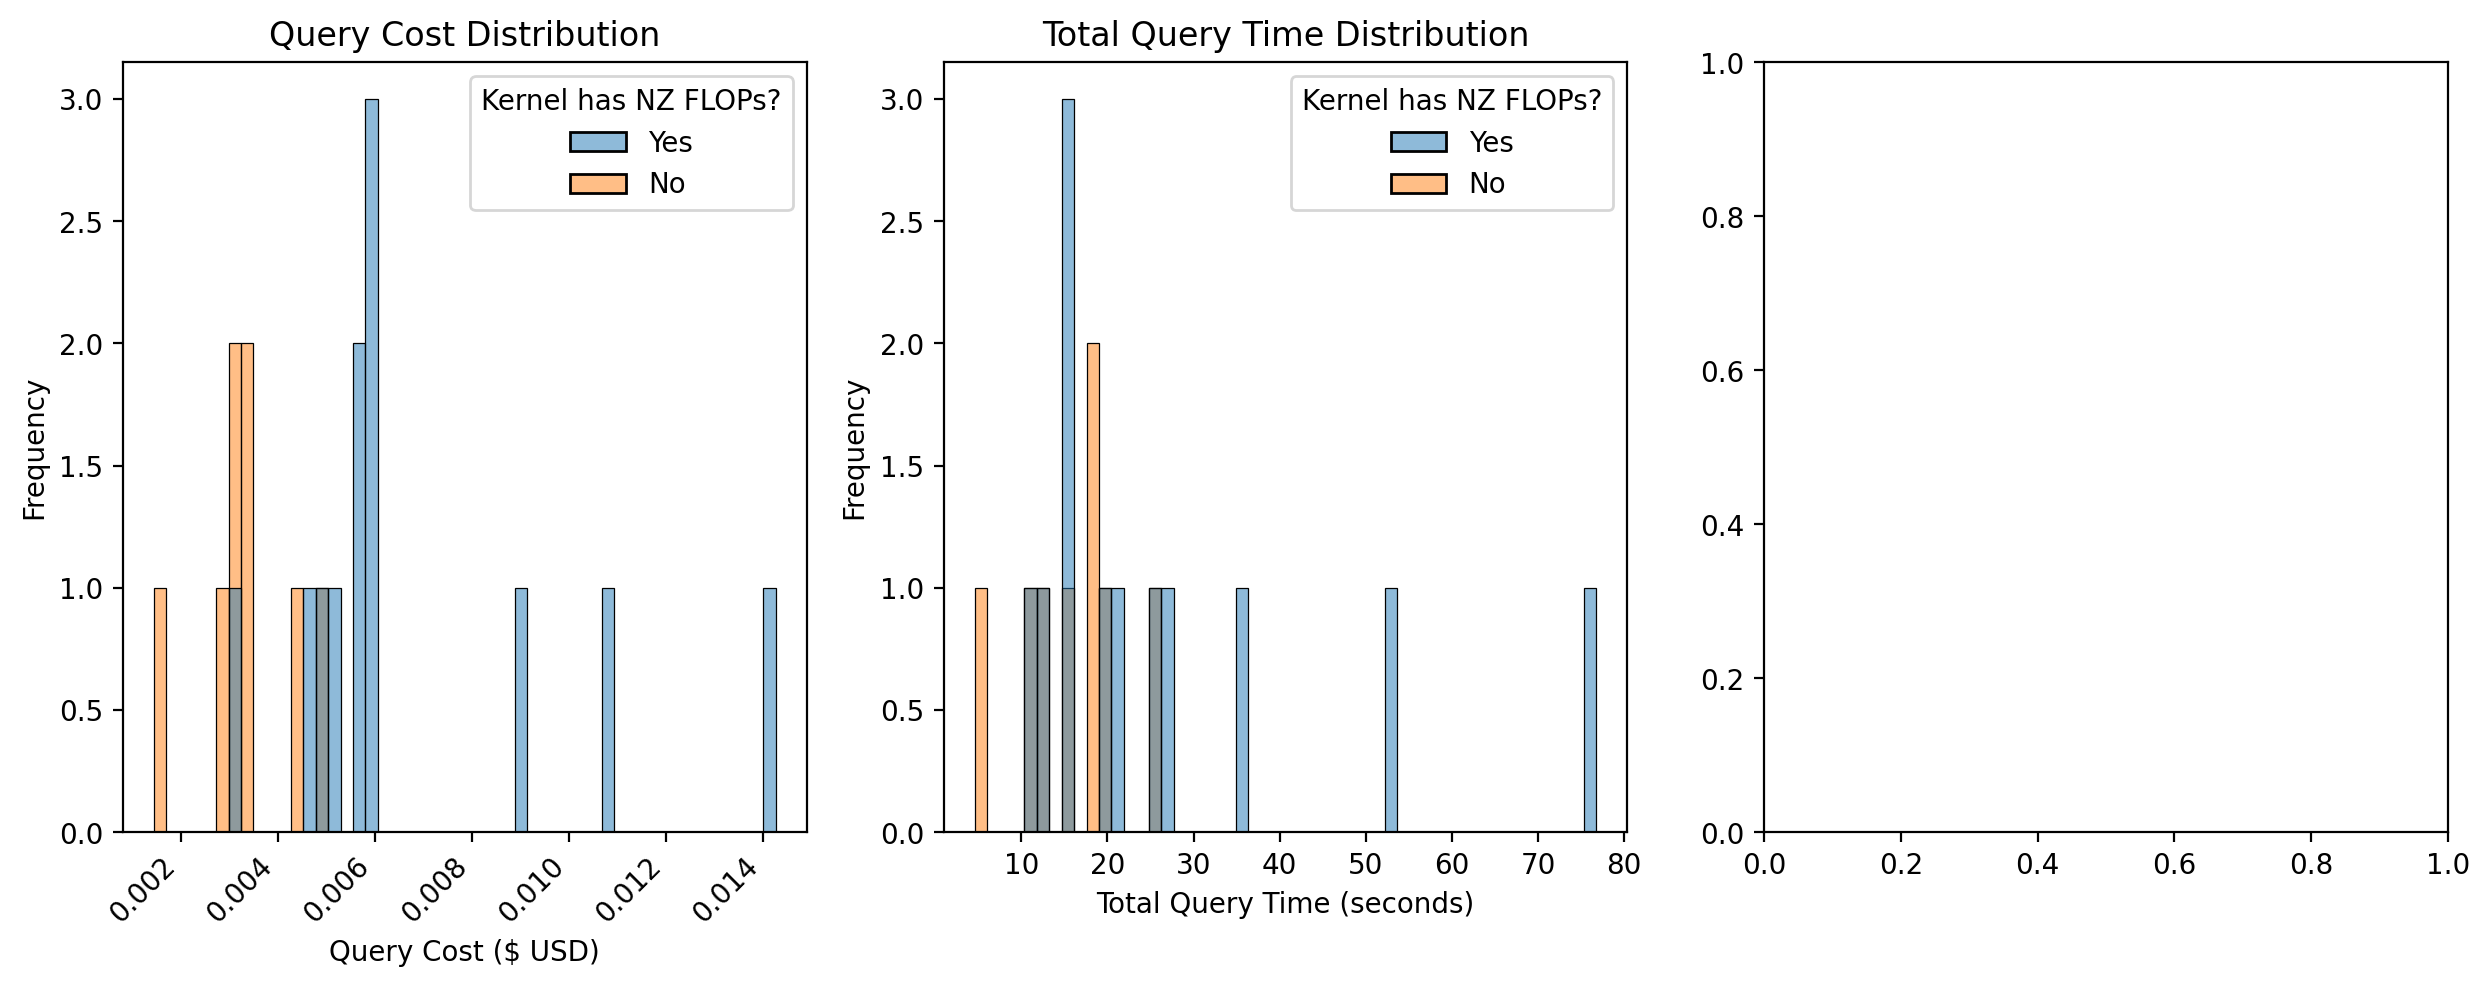

In [9]:
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'full')